<a href="https://colab.research.google.com/github/Myeong2/ComputerVision_Project3-DrinkDetector/blob/master/%EC%A3%BC%EC%8B%9D%EC%98%88%EC%B8%A1%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from google.colab import files

In [22]:
# Upload the CSV file
uploaded = files.upload()

Saving TSLA.csv to TSLA (2).csv


In [23]:
# Read the CSV file
csv_data = list(uploaded.keys())[0]
stock_data = pd.read_csv(csv_data)
stock_data.drop(['Adj Close'], axis=1, inplace=True)  # Delete adjusted close

In [26]:
# Save original 'Open' prices for later
original_open = stock_data['Open'].values

# Separate dates for future plotting
dates = pd.to_datetime(stock_data['Date'])

# Variables for training
cols = list(stock_data)[1:6]

# New dataframe with only training data - 5 columns
stock_data = stock_data[cols].astype(float)

In [27]:
# Normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

# Split the data into train and test sets
n_train = int(0.9 * stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = dates[n_train:]

In [28]:
# Data reformatting for LSTM
pred_days = 1  # Prediction period
seq_len = 14  # Sequence length = past days for future prediction.
input_dim = 5  # Input dimension = ['Open', 'High', 'Low', 'Close', 'Volume']

trainX = []
trainY = []
testX = []
testY = []

In [29]:
for i in range(seq_len, n_train - pred_days + 1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled) - pred_days + 1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [30]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Specify your learning rate
learning_rate = 0.01
# Create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# Compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')


No weights found, training model from scratch
Epoch 1/30
6/6 [==============================] - 0s 41ms/step - loss: 0.0124 - val_loss: 0.0257
Epoch 2/30
6/6 [==============================] - 0s 40ms/step - loss: 0.0109 - val_loss: 0.0169
Epoch 3/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0097 - val_loss: 0.0167
Epoch 4/30
6/6 [==============================] - 0s 34ms/step - loss: 0.0096 - val_loss: 0.0281
Epoch 5/30
6/6 [==============================] - 0s 25ms/step - loss: 0.0092 - val_loss: 0.0129
Epoch 6/30
6/6 [==============================] - 0s 32ms/step - loss: 0.0104 - val_loss: 0.0212
Epoch 7/30
6/6 [==============================] - 0s 28ms/step - loss: 0.0088 - val_loss: 0.0149
Epoch 8/30
6/6 [==============================] - 0s 41ms/step - loss: 0.0087 - val_loss: 0.0173
Epoch 9/30
6/6 [==============================] - 0s 28ms/step - loss: 0.0084 - val_loss: 0.0182
Epoch 10/30
6/6 [==============================] - 0s 21ms/step - loss: 0.0091 - 

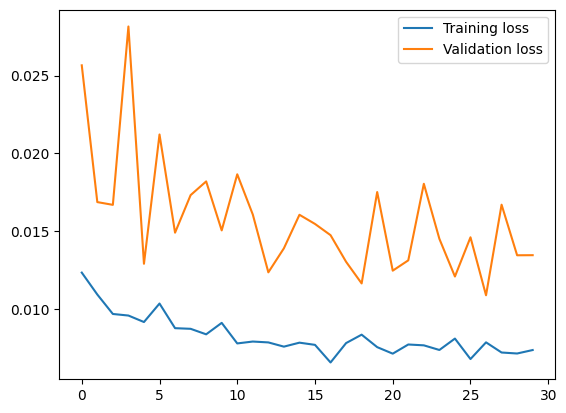

In [33]:
import os
from google.colab import files

# Create a temporary directory to store model weights
weights_dir = '/content/temp_weights/'

# Create the directory if it doesn't exist
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# ...

# Try to load weights
try:
    model.load_weights(os.path.join(weights_dir, 'lstm_weights.h5'))
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights(os.path.join(weights_dir, 'lstm_weights.h5'))

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

In [38]:
# Prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# Generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# Substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# Inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:, 0]
print(y_pred.shape)

# Generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# Substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# Inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:, 0]
print(testY_original.shape)

# Plotting
plt.figure(figsize=(14, 5))

1/1 [==============================] - 0s 20ms/step
(12, 1) (12, 1)
(12,)
(12,)


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

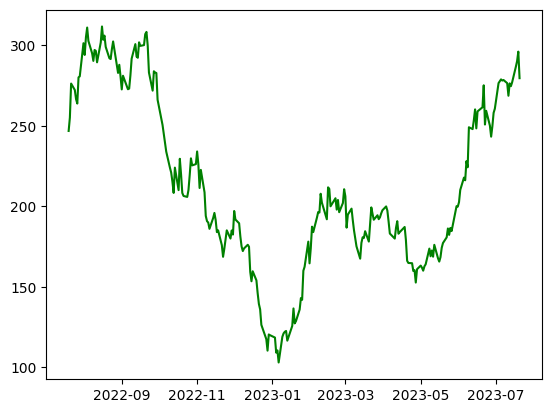

In [59]:
# Plot original 'Open' prices
plt.plot(dates, original_open, color='green', label='Original Open Price')


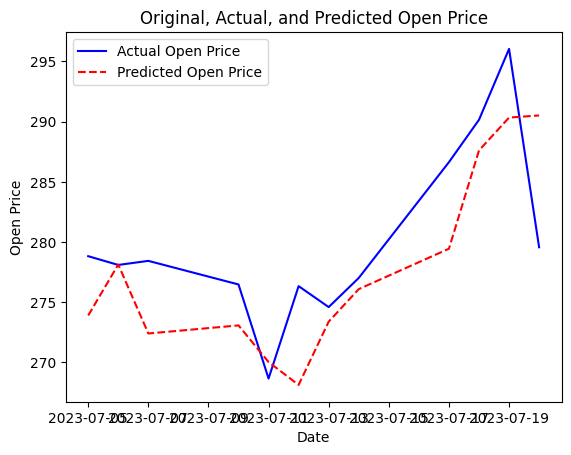

In [40]:
# Plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original, Actual, and Predicted Open Price')
plt.legend()
plt.show()

In [42]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)


In [43]:
# Create the zoomed plot
plt.figure(figsize=(14, 5))


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

In [ ]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Adjust the start and end indices for test_dates, testY_original, and y_pred arrays
adjusted_start = zoom_start - seq_len
adjusted_end = zoom_end - seq_len

plt.plot(test_dates[adjusted_start:adjusted_end],
         testY_original[adjusted_start:adjusted_end],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[adjusted_start:adjusted_end],
         y_pred[adjusted_start:adjusted_end],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Zoomed In Actual vs Predicted Open Price')
plt.legend()
plt.show()

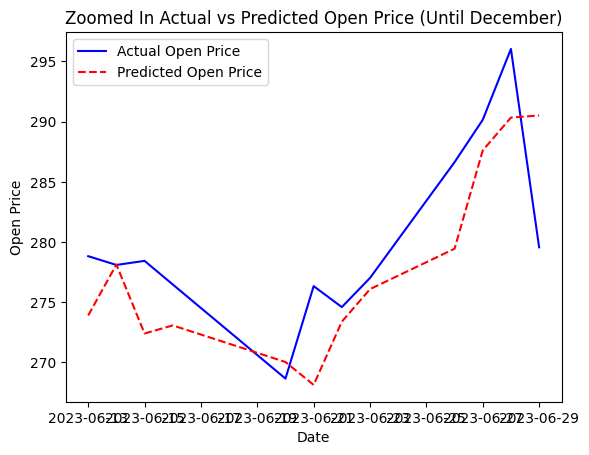

In [58]:
import datetime

# ...

# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Adjust the start and end indices for test_dates, testY_original, and y_pred arrays
adjusted_start = zoom_start - seq_len
adjusted_end = zoom_end - seq_len

# Get the index corresponding to December of the current year (if it exists)
current_year = datetime.datetime.now().year
december_indices = [i for i, date in enumerate(test_dates) if date.year == current_year and date.month == 12]

if december_indices:
    # If there are December indices, use the last one
    december_index = december_indices[-1]
else:
    # If there are no December indices, use the end index
    december_index = adjusted_end

# Use the data up to December for plotting
plt.plot(test_dates[adjusted_start:december_index],
         testY_original[adjusted_start:december_index],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[adjusted_start:december_index],
         y_pred[adjusted_start:december_index],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Zoomed In Actual vs Predicted Open Price (Until December)')
plt.legend()
plt.show()

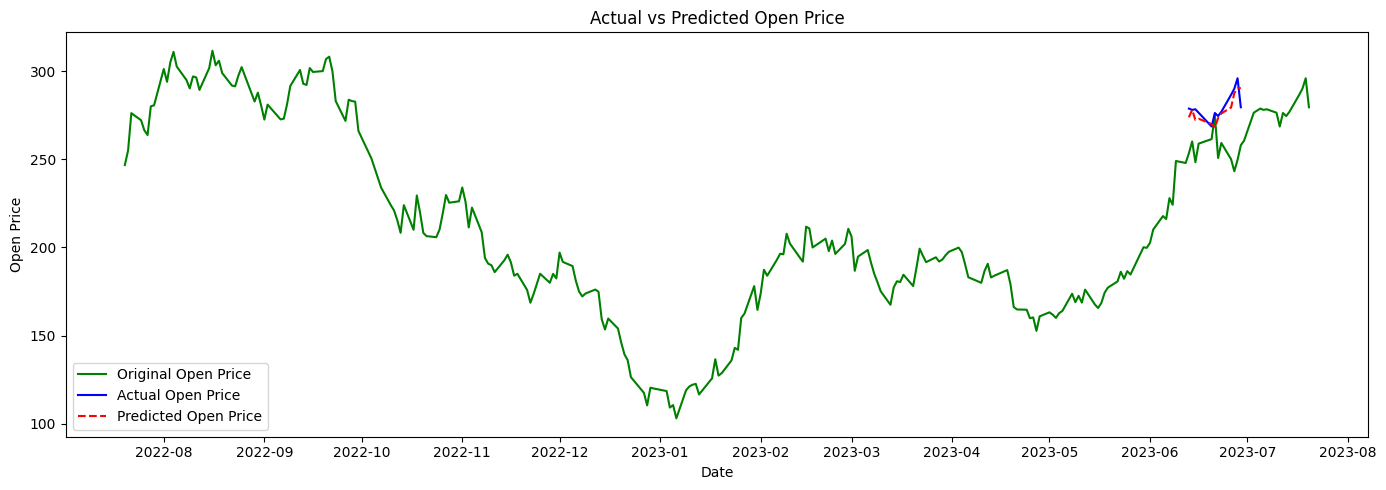

In [56]:
import datetime
import matplotlib.dates as mdates

# ...

# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Adjust the start and end indices for test_dates, testY_original, and y_pred arrays
adjusted_start = zoom_start - seq_len
adjusted_end = zoom_end - seq_len

# Use the data for plotting, including future predictions for the remaining part of the year
current_year = datetime.datetime.now().year
end_of_year = datetime.datetime(current_year, 12, 31)  # Last day of the current year

# Find the index corresponding to the end of the year
december_index = next((i for i, date in enumerate(test_dates) if date > end_of_year), adjusted_end)

# Plotting
plt.figure(figsize=(14, 5))

# Original 'Open' price plot
plt.plot(dates, original_open, color='green', label='Original Open Price')

# Actual and predicted price plot
plt.plot(test_dates[:adjusted_end],
         testY_original[:adjusted_end],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[:adjusted_end],
         y_pred[:adjusted_end],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

# Adding future predictions
plt.plot(test_dates[adjusted_end:december_index],
         testY_original[adjusted_end:december_index],
         color='blue',
         alpha=0.5)

plt.plot(test_dates[adjusted_end:december_index],
         y_pred[adjusted_end:december_index],
         color='red',
         linestyle='--',
         alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Actual vs Predicted Open Price')

# Format x-axis date ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.tight_layout()
plt.show()